# **Moving beyond linearity**

Welcome back!

This notebook contains Python code for the lecture on nonlinear models (moving *beyond linearity*) for the course *Introduction to data science* and includes a set of exercises as well.

<p>
Basis extension methods provide an elegant means to model non-linear relationships in datasets. Their main purpose is to transform data into a (often high-dimensional) feature space in which the relevant patterns can be discoverd using linear methods. 
<center><a href="https://commons.wikimedia.org/wiki/File:Kernel_Machine.svg#/media/File:Kernel_Machine.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Kernel_Machine.svg/1200px-Kernel_Machine.svg.png" alt="Scatterplot featuring a linear support vector machine's decision boundary (dashed line)" width="350"></a> </center> </p>


## Import Libraries

To add functionality to your Python session, a series of libraries (most importantly scikit-image and scikit-learn are imported)

In [1]:
# import numpy for array manipulation
import numpy as np
# import matplotlib for visualization
import matplotlib.pyplot as plt
# import pandas
import pandas as pd

# import linear models and some convenience functions to create dummy data, plot decision boundaries ad split train and test data
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import sklearn.metrics.pairwise as pairwise
from sklearn.kernel_ridge import KernelRidge


## 1. Splines

Sklearn implements B-spline basis functions for spline-based regression. As all spline methods, it consists of a basis of local polynomials (polynomials with a local support) of a given degree (often ``degree = 3``). The image below illustrates a simple polynomial basis functions (left) and a B-spline basis functions of degree three (right) and four knot positions.

<center><img src="https:\\users.ugent.be\~jverwaer\bsplines_sklearn.png" alt="B-spline basis" width="450"></center>

**STEP 1**: load the data

*To illustrate the splines for regression, we will use a QSAR dataset. Quantitative structure-activity relationship (QSAR) is a computational or mathematical modeling method to reveal relationships between biological activities and the structural properties of chemical compounds. The data we use contains 6 molecular descriptors of 908 different compounds. The objective is to predict the toxicity of these compounds. The target is the LC50 (the abbreviation used for the exposure concentration of a toxic substance lethal to half of the test animals) and is expressed in -LOG(mol/L).*

In [ ]:
# importing the qsar dataset
fname = "qsar_fish_toxicity.csv"
qsar_df = pd.read_csv(fname, sep=";")

# extract X and y as two numpy arrays
X = qsar_df.iloc[:,0:6].to_numpy()  
y = qsar_df.iloc[:,6].to_numpy()

**STEP 2**: create train/tune/test splits

In [ ]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 150, random_state=1)
# split tune from train data
X_train, X_tune, y_train, y_tune = train_test_split(X_train, y_train, test_size = 50, random_state=1)

# standardize the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_tune = scaler.transform(X_tune)
X_test = scaler.transform(X_test)

**STEP 3**: create spline features

In [ ]:
# create a spline transformer object
spline = SplineTransformer(degree=2, n_knots=5, knots='quantile')

# call the fit method to compute the knot positions
spline.fit(X_train)

# transform the data
X_train = spline.transform(X_train)
X_tune = spline.transform(X_tune)
X_test = spline.transform(X_test)

**STEP 4**: do ridge regression on the resulting spline features

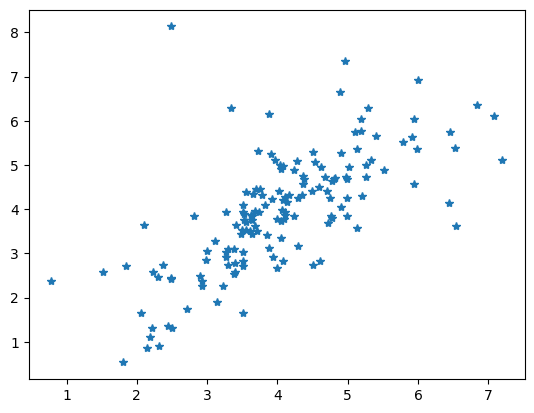

In [ ]:
# create model object
mdl = Ridge(alpha = 0.5)

# fit the model
mdl.fit(X_train, y_train)

# make predictions on test set
predictions = mdl.predict(X_test)

# make a plot
plt.plot(predictions, y_test, "*")

**STEP 5**: Tune the regularization parameter

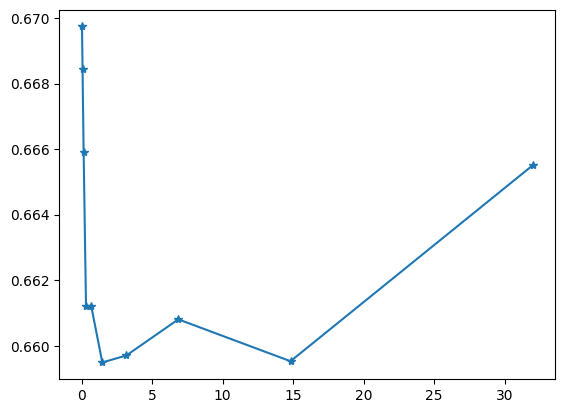

In [ ]:
alphas = 2**np.linspace(-5, 5, 10)
MAEs = []
for a in alphas:
    # create model object
    mdl = Ridge(alpha = a)

    # fit the model
    mdl.fit(X_train, y_train)

    # make predictions on tuning set
    predictions = mdl.predict(X_tune)

    # compute MAE
    MAEs.append(np.mean(np.abs(predictions - y_tune)))

plt.plot(alphas, MAEs, '-*')

**STEP 6**: Build and test final model using tuned $\alpha$ on test set

In [ ]:
# find best alpha (this is the automated way but can also be done visually)
idx = np.array(MAEs).argmin()
best_alpha = alphas[idx]

# build model with best alpha and test
mdl = Ridge(alpha = best_alpha)
mdl.fit(X_train, y_train)
predictions = mdl.predict(X_test)

# compute MAE
MAE = np.mean(np.abs(predictions - y_test))

print('Best alpha:', best_alpha)
print('MAE on test set:', MAE)

Best alpha: 1.4697344922755986
MAE on test set: 0.6862338528847295


**EXERCISE**: Use a spline-basis in combination with Ridge regression to build a model to predict the price of a car (we have used and cleaned this dataset before and a *cleaned* version is available data available in ``car_price_nice.csv`` the last column is the price (output)). Use $\alpha = 4$, ``degree``= 2 and ``n_knots``= 6  (we will see how to automatically find optimal values efficiently later in this notebook).

In [ ]:
# to be completed ...

## 2. Pipelines in sklearn

Working with basis functions often imples that data are first scaled, spline features are computed and subsequently a model is fit. Scaling and feature computation are proprocessing steps that need to be repeated on the train, tune and test sets leading to repetetive coding. ``Pipeline``s allow to avoid this and tie a series of ``preprocessing`` objects to a regressor/classifier and wrap in into a single object. The most convenient way to build such a pipeline uses the function ``make_pipeline``.

In [ ]:
# importing the qsar dataset
fname = "qsar_fish_toxicity.csv"
qsar_df = pd.read_csv(fname, sep=";")

# extract X and y as two numpy arrays
X = qsar_df.iloc[:,0:6].to_numpy()  
y = qsar_df.iloc[:,6].to_numpy()

In [ ]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 150, random_state=1)
# split tune from train data
X_train, X_tune, y_train, y_tune = train_test_split(X_train, y_train, test_size = 50, random_state=1)

# make a pipeline
mdl = make_pipeline(StandardScaler(),
                    SplineTransformer(degree=2, n_knots=5, knots='quantile'),
                    Ridge(alpha = 0.5))

# scale data, compute spline features and fit model
mdl.fit(X_train, y_train)

# predict on test set (will scale the data, compute spline features etc. automatically before predicting)
predictions = mdl.predict(X_test)

## 3. Parameter tuning with cross-validation

During a (hyper-)parameter tuning procedure, part of the training data is reserved for validation purposes. Especially for small(er) datasets reserving data for validation purposes can significantly reduce the amount of data left for training and thus result in less good models. On the other hand, when the validation set it too small, the valudation accuracy might not be representative and can heavily depend on the (random) split that has been choosen. Cross-validation provides an alternative that uses the training data more efficiently.

<center><a href="https://scikit-learn.org/stable/modules/cross_validation.html"><img src= "https://users.ugent.be/~jverwaer/grid_search_cross_validation.png" alt="Cross-validation" width="350"></a> </center> </p>

Sklearn implements several interfaces to this general idea of cross validation. In this notebook we only use ``GridSearchCV``. Here, *grid* refers to the simultaneous optimization of several (hyper-) parameters by testing all combinations of these parameters where each parameter can take a value in a specified series (hence a grid of combinations).

#### 3.1 Example 1: Tuning $\alpha$ in ridge regression

In [ ]:
# importing the qsar dataset
fname = "qsar_fish_toxicity.csv"
qsar_df = pd.read_csv(fname, sep=";")

# extract X and y as two numpy arrays
X = qsar_df.iloc[:,0:6].to_numpy()  
y = qsar_df.iloc[:,6].to_numpy()

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 150, random_state=1)

# NOTE: to limit the amount of code, no standardization is applied here (should be done in practice!!)

In [ ]:
# define grid of parameters
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# create GridSearchCV object
mdl_cv = GridSearchCV(Ridge(),           # model object (in this case a ridge regressor)
                      param_grid,        # parameter grid
                      cv = 10,           # number of folds
                      scoring = 'neg_mean_absolute_error')  # criterion used to select best model

# perform grid search (after the grid search, mdl_cv.predict(X) will predict using best model)
mdl_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_absolute_error')

In [ ]:
# make predictions using best model on test set
mdl_cv.predict(X_test)

array([2.13076728, 2.36111822, 3.94505905, 4.08642202, 1.63374929,
       2.73395482, 2.47799089, 4.96018913, 2.93742619, 4.14350472,
       3.93946381, 4.07299202, 2.44055427, 5.0040515 , 3.91988007,
       2.59112025, 4.68780623, 3.75823826, 7.29087307, 2.5893699 ,
       3.90355523, 4.26816816, 5.42930581, 2.50777588, 3.68711486,
       4.8171917 , 2.99965457, 2.8890459 , 1.36189051, 3.97148456,
       4.43358919, 3.57594642, 2.4575401 , 2.89449801, 3.43773512,
       8.28920109, 3.77133153, 3.75958338, 3.09918312, 3.12268395,
       4.73298911, 5.21778584, 4.77872437, 4.09938029, 3.65959634,
       5.12795661, 3.45202823, 6.09742678, 5.34186322, 5.09242931,
       5.11313106, 4.19305438, 0.04587365, 4.18549696, 2.81589901,
       3.87414399, 4.04154518, 3.21254782, 4.35321374, 3.3518679 ,
       4.56885596, 2.4575401 , 3.48803358, 4.99864065, 4.16497829,
       5.88868737, 5.91912793, 4.65010504, 1.42292378, 2.31617336,
       7.47431175, 6.71196539, 4.14175076, 4.238146  , 3.48777

In [ ]:
# inspect the full cross validation results
pd.DataFrame(mdl_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001415,0.001123,0.000415,0.000145,0.001,{'alpha': 0.001},-0.715609,-0.782622,-0.513120,-0.709739,-0.671947,-0.745460,-0.740166,-0.721761,-0.553216,-0.766586,-0.692023,0.085072,4
1,0.000700,0.000037,0.000314,0.000013,0.01,{'alpha': 0.01},-0.715609,-0.782618,-0.513118,-0.709746,-0.671946,-0.745448,-0.740175,-0.721767,-0.553207,-0.766583,-0.692022,0.085073,3
2,0.000769,0.000147,0.000397,0.000160,0.1,{'alpha': 0.1},-0.715614,-0.782573,-0.513099,-0.709810,-0.671934,-0.745325,-0.740269,-0.721824,-0.553114,-0.766553,-0.692012,0.085086,2
3,0.000736,0.000045,0.000307,0.000008,1,{'alpha': 1},-0.715736,-0.782144,-0.512969,-0.710442,-0.671813,-0.744258,-0.741188,-0.722383,-0.552202,-0.766251,-0.691938,0.085217,1
4,0.000738,0.000062,0.000336,0.000056,10,{'alpha': 10},-0.717543,-0.782984,-0.515417,-0.716656,-0.672512,-0.737993,-0.750711,-0.729155,-0.551839,-0.763437,-0.693825,0.085298,5
5,0.000700,0.000017,0.000318,0.000028,100,{'alpha': 100},-0.758326,-0.821331,-0.555167,-0.752998,-0.690008,-0.739941,-0.810786,-0.764759,-0.593273,-0.763525,-0.725011,0.083211,6
6,0.000691,0.000014,0.000305,0.000012,1000,{'alpha': 1000},-0.950001,-0.956960,-0.737420,-0.912127,-0.797363,-0.827099,-0.889342,-0.873763,-0.730945,-0.844189,-0.851921,0.075864,7


#### 3.1 Example 2: Tuning $\alpha$ and ``n_knots`` in for B-splines

In [ ]:
# make a pipeline
mdl = make_pipeline(StandardScaler(),
                    SplineTransformer(degree=2, n_knots=5, knots='quantile'),
                    Ridge())

# define grid of parameters
# small notes: 
#      * ridge__  refers to the ridge regressor in the pipeline (we cannot just use alpha as the
#               ridge regressor is embeddid in a pipelin)
#      * splinetransformer__  refers to the spline transformer in the same way, the convention is
#                             to use the class-names of the elements of the pipeline in lowercase
                             
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000],
              'splinetransformer__n_knots': [2, 4, 6, 8, 10, 12]}

# create GridSearchCV object
mdl_cv = GridSearchCV(mdl,               # model object (in this case the pipeline)
                      param_grid,        # parameter grid
                      cv = 10,           # number of folds
                      scoring = 'neg_mean_absolute_error')  # criterion used to select best model

# perform grid search (after the grid search, mdl_cv.predict(X) will predict using best model)
mdl_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('splinetransformer',
                                        SplineTransformer(degree=2,
                                                          knots='quantile')),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000],
                         'splinetransformer__n_knots': [2, 4, 6, 8, 10, 12]},
             scoring='neg_mean_absolute_error')

In [ ]:
# look at the best parameters
mdl_cv.best_params_

{'ridge__alpha': 1, 'splinetransformer__n_knots': 8}

**EXERCISE**: Implement a full-fledged model selection procedure to build a model that is capable of predicting the price of a car (data available in ``car_price_nice.csv``) using:
-  Lasso regression on a B-spline basis;
-  Cross validation to tune the *number of knots*, the *degree* and *alpha*; 

Test the performance (MAE) on the test set.

In [ ]:
# step 1: load data
fname = "car_price_nice.csv"
qsar_df = pd.read_csv(fname, sep=",", header = None)

# extract X and y as two numpy arrays
X = qsar_df.iloc[:,0:64].to_numpy()  
y = qsar_df.iloc[:,64].to_numpy()

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 40, random_state=1)

In [ ]:
# step 2 :make pipeline and do grid search

# make a pipeline
mdl = make_pipeline(StandardScaler(),
                    SplineTransformer(degree=2, n_knots=5, knots='quantile'),
                    Lasso())
                             
param_grid = {'lasso__alpha': [0.01, 0.1, 1, 10, 100, 1000],
              'splinetransformer__n_knots': [2, 4, 6, 8, 10, 12],
              'splinetransformer__degree' : [2, 3, 4, 5]}

# create GridSearchCV object
mdl_cv = GridSearchCV(mdl,               # model object (in this case the pipeline)
                      param_grid,        # parameter grid
                      cv = 10,           # number of folds
                      scoring = 'neg_mean_absolute_error')  # criterion used to select best model

# perform grid search (after the grid search, mdl_cv.predict(X) will predict using best model)
mdl_cv.fit(X_train, y_train)


In [ ]:
mdl_cv.best_params_

{'lasso__alpha': 1,
 'splinetransformer__degree': 5,
 'splinetransformer__n_knots': 2}

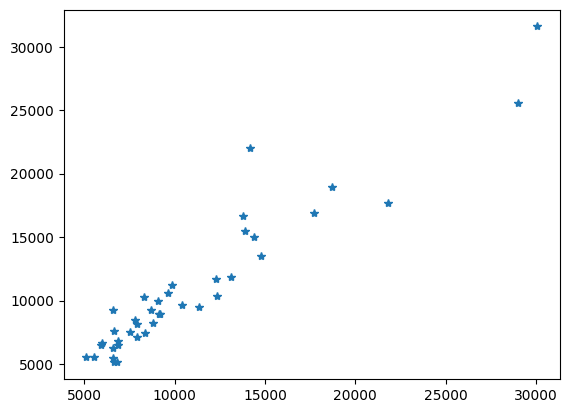

In [ ]:
np.mean(np.abs(mdl_cv.predict(X_test) - y_test))

plt.plot(mdl_cv.predict(X_test), y_test, '*')

## 3. Kernel methods

Kernel-based methods use the Kernel-trick to efficiently fit models in (very) high-dimensional feature spaces. The kernel defines the type of feature space to use. The space can use a polynomial basis, spline basis, radial basis, ... . Once a kernel function is selected, the regularized loss can be minimized. The model $f$ is now parameterized using $n+1$ parameters:

$$ f(\mathbf{x}) = \beta_0 +  \sum_{i = 1}^n \alpha_i \, \kappa(\mathbf{x}, \mathbf{x}_{i}) $$

These parameters are estimated by minimizing the following loss function:

$$ L_{\text{ridge}}(\beta_0, \alpha_1, \ldots, \alpha_n) = \sum_{i=1}^n (y_i - f(\mathbf{x}_i))^2  + \lambda \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j \kappa(\mathbf{x}_i, \mathbf{x}_{j}) $$


This estimation procedure is implemented by the class ``KernelRidge``. This class can accept a series of default kernels, an overview of built-in kernels can be found in ``pairwise.PAIRWISE_KERNEL_FUNCTIONS``. User-defined kernels can also be provided.


In [ ]:
pairwise.PAIRWISE_KERNEL_FUNCTIONS

{'additive_chi2': <function sklearn.metrics.pairwise.additive_chi2_kernel(X, Y=None)>,
 'chi2': <function sklearn.metrics.pairwise.chi2_kernel(X, Y=None, gamma=1.0)>,
 'linear': <function sklearn.metrics.pairwise.linear_kernel(X, Y=None, dense_output=True)>,
 'polynomial': <function sklearn.metrics.pairwise.polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1)>,
 'poly': <function sklearn.metrics.pairwise.polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1)>,
 'rbf': <function sklearn.metrics.pairwise.rbf_kernel(X, Y=None, gamma=None)>,
 'laplacian': <function sklearn.metrics.pairwise.laplacian_kernel(X, Y=None, gamma=None)>,
 'sigmoid': <function sklearn.metrics.pairwise.sigmoid_kernel(X, Y=None, gamma=None, coef0=1)>,
 'cosine': <function sklearn.metrics.pairwise.cosine_similarity(X, Y=None, dense_output=True)>}

**STEP 1**: Load and standardize the data

In [ ]:
# see above for dataloading, we assume that all have been scaled and
# X_train, X_test, y_train, y_test are available in memory

**STEP 2**: define, fit and predict

Note that every kernel comes with some parameters. For a polynomial kernel, the kernel function is:

$$ \kappa(\mathbf{x}, \mathbf{x}') = (\text{\texttt{gamma }} \langle \mathbf{x}, \mathbf{x}' \rangle, + \text{\texttt{coef0}})^{\text{\texttt{degree}}} $$

where ``gamma = 1/n`` is a reasonable default, the degree determines the order of the polynomial basis and should be tuned (typically using a grid search over ``[1, 2, 3]``) and ``coef0 = 1`` is also a reasonable default.

In [ ]:
# create model object
mdl = KernelRidge(alpha = 0.1,      # note that alpha is the regularization parameter here (delta in the formula)
                  kernel = "poly",
                  degree = 2)

# fit model
mdl.fit(X_train, y_train)

# make predictions
mdl.predict(X_test)

**EXERCISE**: The RBF-kernel is one of the most popular kernels used in practice. A ridge regression model with and RBF kernel is a *univeral approximator* which means that these models can approximate any function with arbitrary precision (as opposed to polynomial models wich, naturally, only can model polynomial functions). This kernelis of the form:

$$ \kappa(\mathbf{x}, \mathbf{x}') = e^{- \text{\texttt{gamma }} \sum_{j = 1}^p (x_j - x'_j)^2 }  $$

where ``gamma`` is a kernel parameter that is related to the length scale ($1/\gamma^2$) large values for ``gamma`` allow the model to vary quickly whereas smaller values for ``gamma`` will lead to less variable approximations. This parameter is typically tuned along with the regularization parameter. The default is to set it equal to $1/n$ (which is often a reasonable choice).

- Use an RBF-kernel to predict car-prices using the ``car_price_nice.csv`` dataset.
- Tune ``gamma`` over the range (0.0001, 0.001, 0.01, 0.1, 1, 10, 100) and regularization parameter $\alpha$ using a grid search 


In [ ]:
# step 1: load data
fname = "car_price_nice.csv"
qsar_df = pd.read_csv(fname, sep=",", header = None)

# extract X and y as two numpy arrays
X = qsar_df.iloc[:,0:64].to_numpy()  
y = qsar_df.iloc[:,64].to_numpy()

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 40, random_state=1)

In [ ]:
# make a pipeline
mdl = make_pipeline(StandardScaler(),
                    KernelRidge(kernel = "rbf"))
                             
param_grid = {'kernelridge__alpha': [0.01, 0.1, 1, 10, 100, 1000],
              'kernelridge__gamma': [0.01, 0.1, 1, 10, 100, 1000]}

# create GridSearchCV object
mdl_cv = GridSearchCV(mdl,               # model object (in this case the pipeline)
                      param_grid,        # parameter grid
                      cv = 10,           # number of folds
                      scoring = 'neg_mean_absolute_error')  # criterion used to select best model

# perform grid search (after the grid search, mdl_cv.predict(X) will predict using best model)
mdl_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kernelridge',
                                        KernelRidge(kernel='rbf'))]),
             param_grid={'kernelridge__alpha': [0.01, 0.1, 1, 10, 100, 1000],
                         'kernelridge__gamma': [0.01, 0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_absolute_error')

In [ ]:
mdl_cv.best_params_

{'kernelridge__alpha': 0.1, 'kernelridge__gamma': 0.01}

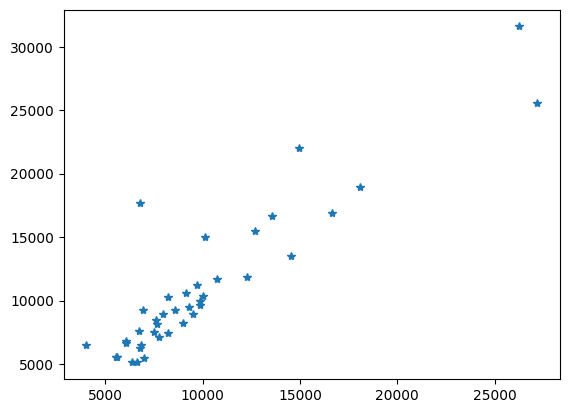

In [ ]:
plt.plot(mdl_cv.predict(X_test), y_test, '*')

In [ ]:
np.mean(np.abs(mdl_cv.predict(X_test) - y_test))

1579.6971978084905

## 4. Support vector classification 

Support vector classification is implemented by the class ``SVC`` an fits of model of the form.

$$ f(\mathbf{x}) = \beta_0 +  \sum_{i = 1}^n \alpha_i \, \kappa(\mathbf{x}, \mathbf{x}_{i}) $$
where $\kappa$ is a kernel function (inspect the documentation https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC for an overview of potential kernels).  The trade-off between model fit and model compexity is set by the parameter ``C`` in the following optimization problem (which means that large ``C`` gives less regularization).

$$\sum_{j=1}^n \alpha_i \alpha_j \kappa(\mathbf{x}_i, \mathbf{x}_{j})  + C \left[ \frac1n \sum_{i=1}^n \text{max}(0, 1-y_i f(\mathbf{x}_i))   \right]$$



In [14]:
# create some toy data
from sklearn.datasets import make_gaussian_quantiles
X_dummy, y_dummy = make_gaussian_quantiles(n_features=2, n_classes=3, n_samples=5000)

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y_dummy, test_size = 40, random_state=1)

# create a model isntance
mdl = SVC(C = 2, kernel = 'rbf', gamma = 1/5)

# fit a model
mdl.fit(X_train, y_train)

# predict on test set
predictions = mdl.predict(X_test)

# compute accuracy
sum(predictions == y_test)/len(y_test)

0.975

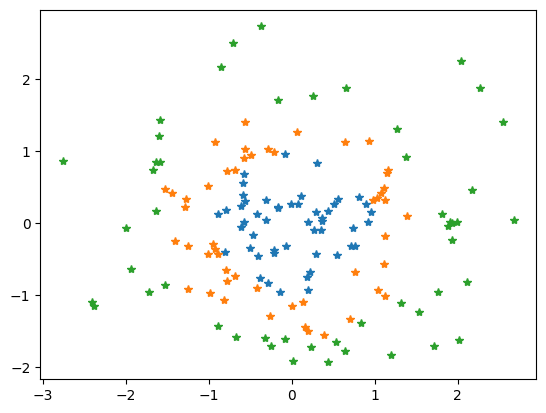

In [13]:
for i in range(0,3):
  plt.plot(X_dummy[y_dummy == i,0], X_dummy[y_dummy == i,1], '*')

**EXERCISE**: The wine dataset is a 3-class classification dataset where the goal is to predict the grape cultivar that was used to produce a wine using 13 chemical properties of the wine (https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-dataset). This dataset is one of the built-in datasets in SKLearn. 

To do:
- Construct a support vector classifier that can predict the cultivar. 
- Tune the regularization parameter and the hyperparameter $\gamma$ of the RBF kernel using cross-validation.
- Compute the performance of the final model on a hold-out test set

In [16]:
from sklearn.datasets import load_wine

# load dataset
data = load_wine()

# extract X and y
X = data.data
y = data.target

# print some information
print(data.feature_names)
print(data.target_names)

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']


In [19]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 40, random_state=1)

# make a pipeline
mdl = make_pipeline(StandardScaler(),
                    SVC(kernel = "rbf"))

# use grid search to tune the parameter
parameter_grid = {"svc__C" : [0.001, 0.1, 1, 10, 100],
                  "svc__gamma" : [0.001, 0.1, 1, 10, 100]}

mdl_cv = GridSearchCV(estimator = mdl,
                      param_grid = parameter_grid,
                      cv = 10)

mdl_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.001, 0.1, 1, 10, 100],
                         'svc__gamma': [0.001, 0.1, 1, 10, 100]})

In [21]:
mdl_cv.best_params_

{'svc__C': 1, 'svc__gamma': 0.1}

In [22]:
predictions = mdl_cv.predict(X_test)

np.sum(predictions == y_test)/len(y_test) 

0.975

In [24]:
X_test

array([[1.369e+01, 3.260e+00, 2.540e+00, 2.000e+01, 1.070e+02, 1.830e+00,
        5.600e-01, 5.000e-01, 8.000e-01, 5.880e+00, 9.600e-01, 1.820e+00,
        6.800e+02],
       [1.242e+01, 1.610e+00, 2.190e+00, 2.250e+01, 1.080e+02, 2.000e+00,
        2.090e+00, 3.400e-01, 1.610e+00, 2.060e+00, 1.060e+00, 2.960e+00,
        3.450e+02],
       [1.364e+01, 3.100e+00, 2.560e+00, 1.520e+01, 1.160e+02, 2.700e+00,
        3.030e+00, 1.700e-01, 1.660e+00, 5.100e+00, 9.600e-01, 3.360e+00,
        8.450e+02],
       [1.221e+01, 1.190e+00, 1.750e+00, 1.680e+01, 1.510e+02, 1.850e+00,
        1.280e+00, 1.400e-01, 2.500e+00, 2.850e+00, 1.280e+00, 3.070e+00,
        7.180e+02],
       [1.377e+01, 1.900e+00, 2.680e+00, 1.710e+01, 1.150e+02, 3.000e+00,
        2.790e+00, 3.900e-01, 1.680e+00, 6.300e+00, 1.130e+00, 2.930e+00,
        1.375e+03],
       [1.349e+01, 3.590e+00, 2.190e+00, 1.950e+01, 8.800e+01, 1.620e+00,
        4.800e-01, 5.800e-01, 8.800e-01, 5.700e+00, 8.100e-01, 1.820e+00,
        5.80